In [1]:
### %matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt 

import torch
from torch import nn 
from torch import optim 
import torch.nn.functional as F
from torchvision import datasets, transforms 


In [2]:
import numpy as np

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,),(0.5,))])

trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 64, shuffle = True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download = True, train = False, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True)



In [4]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

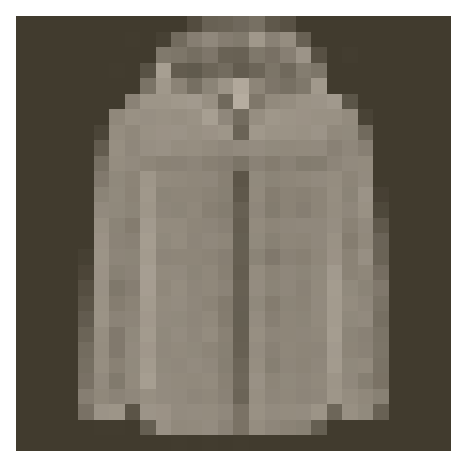

In [5]:
image, label = next(iter(trainloader))
imshow(image[0,:]);

# Build and Train a network

In [14]:
import torch
from torch import nn 
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, drop_p = 0.5):
        '''
        Builds a feedforward network with arbitrary hidden layers.
        Arguments
        ---------
        input_size: integer, size of the input layer
        output_size: integer, size of the output layer 
        hidden_layers: list of integers, the sizes of the hidden layers 
        '''
        
        super().__init__()
        # Input to a hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, hidden_layers[0])])
        
        # Add a variable number of more hidden layers 
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        self.output = nn.Linear(hidden_layers[-1], output_size)
        self.dropout = nn.Dropout(p = drop_p)
    
    def forward(self, x):
        '''
        Forward pass through the network, return the output logits
        '''
        for each in self.hidden_layers:
            x = F.relu(each(x))
            x = self.dropout(x)
        s = self.output(x)
        
        return F.log_softmax(x, dim = 1)
    
def validation(model, testloader, criterion):
    accuracy = 0
    test_loss = 0
    for images, labels  in testloader:
        images = images.resize_(images.size()[0], 784)

        output = model.forward(images)
        test_loss += criterion(output, labels).item()

        ## Calculating the accracy
        # Model's ouput is log-softmax, take exponential to get the prob.
        ps = torch.exp(output)
        # Class with highest probability is our predicted class, compare with true labels
        equality = (labels.data == ps.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
    return test_loss, accuracy 
    

def train(model, trainloader, testloader, criterion, optimizer, epochs=5, print_every = 40):
    steps = 0
    running_loss = 0 
    for e in range(epochs):
        # Model in training mode, dropout is on 
        model.train()
        for images, labels in trainloader:
            steps +=1
            
            # Flatten images into a 784 long vector 
            images.resize_(images.size()[0], 784)
            
            optimizer.zero_grad() 
            
            output = model.forward(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            if steps % print_every == 0:
                # Model in inference mode, dropout is off 
                model.eval()
                
                # Turn off gradients for validation, will speed up inference
                with torch.no_grad():
                    test_loss, accuracy = validation(model, testloader, criterion) 
                print("Epoch: {}/{}".format(e+1, epochs),
                     "Training Loss: {:.3f}..".format(running_loss/print_every),
                     "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
                     "Test Accuracy: {:.3f}..".format(accuracy/len(testloader)))
                
                running_loss = 0
                
                # Make sure dropout and grads are on for training
                model.train()


In [15]:
#%run fc_model.ipynb

model = Network(784, 10, [512, 256, 128])
criterion = nn.NLLLoss() 

optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [16]:
train(model, trainloader, testloader, criterion, optimizer, epochs = 2)

Epoch: 1/2 Training Loss: 3.747.. Test Loss: 2.573.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.217.. Test Loss: 2.079.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.106.. Test Loss: 2.096.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.143.. Test Loss: 1.874.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.103.. Test Loss: 1.939.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.077.. Test Loss: 1.997.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.143.. Test Loss: 2.045.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 2.971.. Test Loss: 1.872.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.069.. Test Loss: 1.958.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 3.067.. Test Loss: 1.712.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 2.991.. Test Loss: 1.843.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 2.978.. Test Loss: 1.680.. Test Accuracy: 0.000..
Epoch: 1/2 Training Loss: 2.942.. Test Loss: 1.668.. Test Accuracy: 0.000..
Epoch: 1/2 T

In [17]:
print("Our model: \n\n", model, '\n')
print("The state dict keys: \n\n", model.state_dict().keys()
     )

Our model: 

 Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5)
) 

The state dict keys: 

 odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


## Let's save the dict the state with "torch.save"

In [18]:
torch.save(model.state_dict(), 'checkpoint.pth')

In [19]:
# and we can load the saved one with "torch.load"
state_dict = torch.load('checkpoint.pth')
print(state_dict.keys())

odict_keys(['hidden_layers.0.weight', 'hidden_layers.0.bias', 'hidden_layers.1.weight', 'hidden_layers.1.bias', 'hidden_layers.2.weight', 'hidden_layers.2.bias', 'output.weight', 'output.bias'])


In [20]:
# to load the state dict in the network, we do "model.load_state_dict(state_dict)"
model.load_state_dict(state_dict)

In [22]:
# Loading the state dict works only if the model architecture is
# exactly the same as the checkpoint architecture

# Try 1
model = Network(784, 10, [400,200,100])
# this will throw an error bcs the tensor sizes are wrong
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for Network:
	size mismatch for hidden_layers.0.weight: copying a param of torch.Size([400, 784]) from checkpoint, where the shape is torch.Size([512, 784]) in current model.
	size mismatch for hidden_layers.0.bias: copying a param of torch.Size([400]) from checkpoint, where the shape is torch.Size([512]) in current model.
	size mismatch for hidden_layers.1.weight: copying a param of torch.Size([200, 400]) from checkpoint, where the shape is torch.Size([256, 512]) in current model.
	size mismatch for hidden_layers.1.bias: copying a param of torch.Size([200]) from checkpoint, where the shape is torch.Size([256]) in current model.
	size mismatch for hidden_layers.2.weight: copying a param of torch.Size([100, 200]) from checkpoint, where the shape is torch.Size([128, 256]) in current model.
	size mismatch for hidden_layers.2.bias: copying a param of torch.Size([100]) from checkpoint, where the shape is torch.Size([128]) in current model.
	size mismatch for output.weight: copying a param of torch.Size([10, 100]) from checkpoint, where the shape is torch.Size([10, 128]) in current model.

In [24]:
# We hanve to rebuild the model exactly as it was when trained. 
# Information about the model architecture needs to be saved in the checkpoint,
# along with the state dict. 
# To do this, we build a dictionary with all the information 
# we need to completely rebuild the model. 

checkpoint = {'input_size': 784,
             'output_size': 10,
             'hidden_layers': [each.out_features for each in model.hidden_layers],
             'state_dict': model.state_dict()}
torch.save(checkpoint, 'checkpoint.pth')

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Network(checkpoint['input_size'],
                   )